### 1. Project Setup and Data Loading
In this section, we import necessary libraries for data manipulation. We then load the Credit Card Default dataset to begin our analysis.

In [180]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve, auc, recall_score, precision_score
import pandas as pd
import numpy as np


data = pd.read_csv("./data/cdp.csv", header=1)
data.head(5)
df = data.copy()


### 2. Data Preprocessing & Encoding
Machine learning models require numerical input. Here, we check for missing values and use `LabelEncoder` to convert categorical text variables (like 'Sex', 'Education', 'Marriage') into numerical format. We also drop columns like `ID` that provide no predictive value.

In [181]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in df:
    if df[col].dtype =='object':
        df[col] = encoder.fit_transform(df[col])

In [182]:
target = 'default payment next month'
print(df.isnull().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


### 3. Exploratory Data Analysis (EDA)
Before modeling, we visualize the relationships between features. The Correlation Matrix helps us identify which variables are most strongly related to the target (`default payment next month`). This gives us early clues about which features (e.g., `PAY_0`, `PAY_2`) might be the most important predictors.

Unique values per column:
ID                            30000
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT6                       6939
PAY_AMT4                       6937
PAY_AMT5                       6897
LIMIT_BAL                        81
AGE                              56
PAY_4                            11
PAY_3                            11
PAY_2                            11
PAY_0                            11
PAY_6                            10
PAY_5                            10
EDUCATION                         7
MARRIAGE                          4
SEX                               2
default payment next month        2
dtype: int64


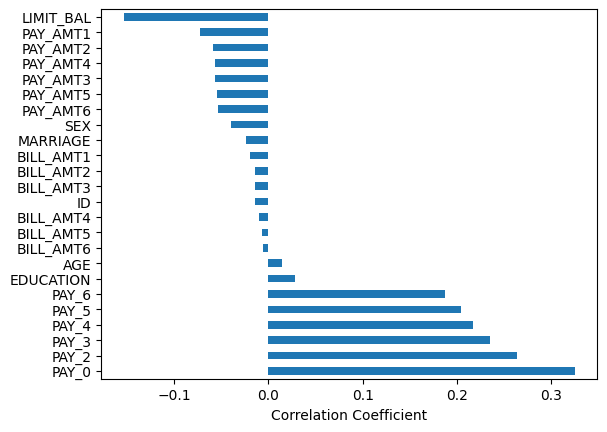

In [183]:
corr = df.corr(numeric_only=True)
corr.head(10)
corr_with_default = corr[target].sort_values(ascending=False)

uniqueRows = df.nunique().sort_values(ascending=False)
print("Unique values per column:")
print(uniqueRows)

#Barplot
corr_with_default.drop(target).plot(kind='barh')
plt.xlabel('Correlation Coefficient')
plt.show() 



I'm dropping `LoanID` because it's just a unique identifier and doesn't help with prediction. I'll keep the other numerical columns since they contain useful continuous data.

In [184]:

df = df.drop(columns=['ID'])
df.dropna(inplace=True)

In [185]:
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [186]:
df[target].value_counts()

default payment next month
0    23364
1     6636
Name: count, dtype: int64

In [187]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### 4. Baseline Model: Naive Bayes
We start with a simple, probabilistic classifier: **Gaussian Naive Bayes**.
* **Why:** It is fast, simple, and serves as a "baseline" benchmark.
* **Goal:** If our advanced models (XGBoost/Neural Networks) cannot beat this simple model, then they are likely not worth the computational cost.

In [188]:
np.random.seed(1234)
randomize_data = df.sample(frac=1) 
train_size = int(0.8 * len(randomize_data))
training = randomize_data[:train_size].reset_index(drop=True)
testing = randomize_data[train_size:].reset_index(drop=True)
print("Training shape:", training.shape)
print("Testing size:", testing.shape)


Training shape: (24000, 24)
Testing size: (6000, 24)


In [189]:
training[target].value_counts(normalize=True)

default payment next month
0    0.777958
1    0.222042
Name: proportion, dtype: float64

In [190]:
testing[target].value_counts(normalize=True)

default payment next month
0    0.782167
1    0.217833
Name: proportion, dtype: float64

In [191]:
trainX = training.iloc[:, :-1]
trainX = training.drop(columns=[target])

trainY = training[target]
colnames = trainX.columns

trainX.head(5)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,400000,1,1,1,34,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1,80000,1,2,2,34,0,0,0,0,0,...,47655,43182,44332,45440,2600,4300,2000,2000,2000,2000
2,200000,2,3,1,49,1,-2,-1,-1,-1,...,2317,7588,7606,14053,0,2317,7588,7614,14053,0
3,20000,2,2,1,41,-1,-1,-1,-1,-1,...,1140,0,7014,7696,1087,1140,0,7014,800,0
4,70000,2,1,1,36,2,0,0,0,0,...,86287,65287,35345,9360,5000,3000,2000,3000,5000,0


In [192]:
testX = testing.iloc[:, :-1]
testX = testing.drop(columns=[target])

testY = testing[target]


In [193]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
trainBrnli = le.fit_transform(trainY)

trainBrnli[:5]

array([0, 0, 0, 0, 0])

In [194]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
trainX = enc.fit_transform(trainX)  
trainX = pd.DataFrame(trainX, columns=colnames)

trainX.head() 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,41.0,0.0,1.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,...,291.0,316.0,311.0,333.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,0.0,2.0,2.0,13.0,2.0,2.0,2.0,2.0,2.0,...,10838.0,10538.0,10652.0,10675.0,2045.0,3080.0,1717.0,1729.0,1701.0,1684.0
2,20.0,1.0,3.0,1.0,28.0,3.0,0.0,1.0,1.0,1.0,...,1625.0,3394.0,3389.0,5163.0,0.0,1824.0,4308.0,4093.0,4931.0,0.0
3,2.0,1.0,2.0,1.0,20.0,1.0,1.0,1.0,1.0,1.0,...,1013.0,316.0,3218.0,3509.0,707.0,753.0,0.0,3970.0,725.0,0.0
4,7.0,1.0,1.0,1.0,15.0,4.0,2.0,2.0,2.0,2.0,...,13987.0,12697.0,9731.0,4027.0,3457.0,2301.0,1717.0,2367.0,3260.0,0.0


Since our features are continuous numbers (like Income, Loan Amount), `GaussianNB` is the right choice here. It assumes the data follows a normal distribution.

In [195]:
model = GaussianNB()  #create model object
model.fit(trainX,trainBrnli) 

,priors,None
,var_smoothing,1e-09


In [196]:
yhattrain = model.predict(trainX)

In [197]:
pd.crosstab(yhattrain, trainY)

default payment next month,0,1
row_0,,
0,16502,2763
1,2169,2566


In [198]:
print("Accuracy: ", str(accuracy_score(yhattrain, trainBrnli)*100) + "%")

Accuracy:  79.45%


In [199]:
print("testX shape:", testX.shape)
print("trainX shape:", trainX.shape)


testX shape: (6000, 23)
trainX shape: (24000, 23)


In [200]:
testBrnli = le.transform(testY)

testX = enc.fit_transform(testX) 

testX = pd.DataFrame(testX, columns=colnames) 
yhattest = model.predict(testX)
yhattest[:9] 


array([0, 0, 0, 0, 1, 0, 0, 1, 0])

In [201]:
acc = accuracy_score(yhattest, testBrnli)
print("Test Accuracy: "+str(acc*100)+"%")


Test Accuracy: 77.46666666666667%


Accuracy is useful, but I want to see the breakdown of errors. The confusion matrix will show us if we're missing actual defaults (False Negatives) or flagging good loans as bad (False Positives).

In [202]:
confM = confusion_matrix(testBrnli, yhattest)
print('Confusion matrix\n', confM)
print('True Negatives = ', confM[0,0])
print('False Positives = ', confM[0,1])
print('False Negatives = ', confM[1,0])
print('True Positives = ', confM[1,1])

Confusion matrix
 [[3924  769]
 [ 583  724]]
True Negatives =  3924
False Positives =  769
False Negatives =  583
True Positives =  724


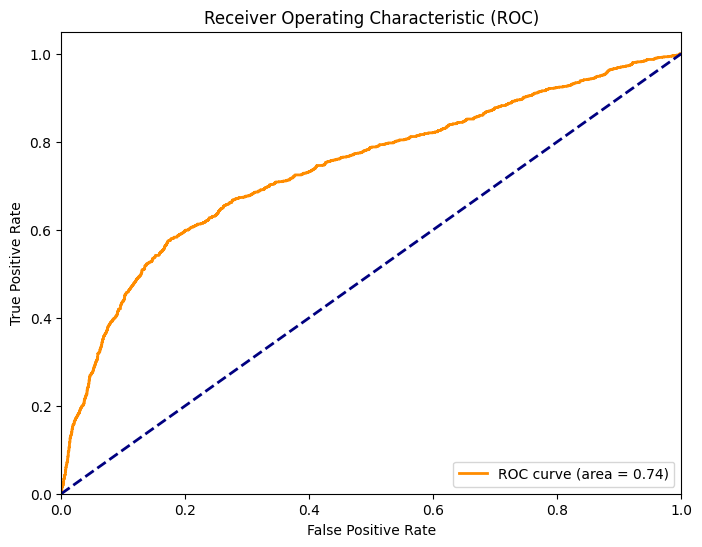

In [203]:
yProb = model.predict_proba(testX)[:,1]
fpr, tpr, thresholds = roc_curve(testBrnli, yProb)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



In [204]:
aucNB = roc_auc_score(testBrnli, yProb)
print("Test AUC: "+str(aucNB))

recNB = recall_score(testBrnli, yhattest)
print("Test Recall: "+str(recNB))

Test AUC: 0.7381861441718126
Test Recall: 0.5539403213465952


### 5. Deep Learning Approach (Neural Network)
Next, we attempt to model non-linear relationships using a Feed-Forward Neural Network built with TensorFlow/Keras.
* **Hyperparameter Tuning:** We use `KerasTuner` to automatically find the best structure (number of layers, neurons, dropout rates) to prevent overfitting.
* **Outcome:** While powerful, Neural Networks can struggle with tabular data compared to tree-based models, especially when the dataset is small or imbalanced.

In [205]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

In [206]:
if 'ID' in data.columns:
    df = data.drop(columns=['ID'])

# Define target
target_col = 'default payment next month'

X = df.drop(columns=[target_col])
y = df[target_col]
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X.head()


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,True,False,True,False,False,False,False,True,False,False
1,120000,26,-1,2,0,0,0,2,2682,1725,...,True,False,True,False,False,False,False,False,True,False
2,90000,34,0,0,0,0,0,0,29239,14027,...,True,False,True,False,False,False,False,False,True,False
3,50000,37,0,0,0,0,0,0,46990,48233,...,True,False,True,False,False,False,False,True,False,False
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,False,False,True,False,False,False,False,True,False,False


In [207]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)


In [208]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
input_dim


30

In [209]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score

# This tells the model how much to "boost" the minority class
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(classes))}
print(f"Computed Class Weights: {class_weights}")


model = Sequential([
    Dense(32, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

#Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#Early Stoppage
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights, 
    verbose=1
)

# --- 5. Evaluate ---
y_proba = model.predict(X_test_scaled)
y_pred = (y_proba >= 0.50).astype(int) 

print(classification_report(y_test, y_pred))
aucNN = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {aucNN:.4f}")

Computed Class Weights: {0: 0.6420202236370446, 1: 2.2603126765869277}
Epoch 1/50


/Users/samuelescarfone/Desktop/Predicting-Credit-Card-Defaults/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - accuracy: 0.6966 - loss: 0.6106 - val_accuracy: 0.7467 - val_loss: 0.5946
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7607 - loss: 0.5795 - val_accuracy: 0.7412 - val_loss: 0.5887
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.7625 - loss: 0.5698 - val_accuracy: 0.7521 - val_loss: 0.5899
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.7659 - loss: 0.5658 - val_accuracy: 0.7617 - val_loss: 0.5738
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.7646 - loss: 0.5609 - val_accuracy: 0.7654 - val_loss: 0.5552
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7656 - loss: 0.5585 - val_accuracy: 0.7271 - val_loss: 0.5951
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.7657 - loss: 0.5557 - val_accuracy: 0.7523 - val_loss: 0.5707
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.7664 - loss: 0.5536 - val_accuracy:

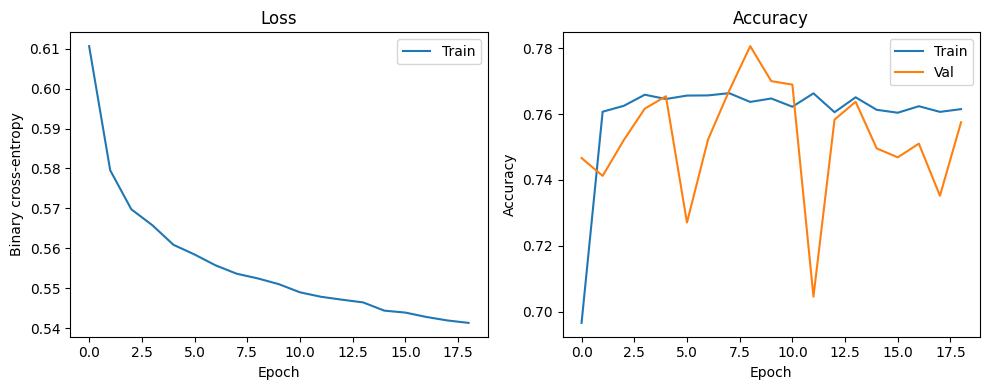

In [210]:
plt.figure(figsize=(10,4))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [216]:

accNN = accuracy_score(y_test, y_pred)
recNN = recall_score(y_test, y_pred)
aucNN = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {accNN:.4f}")
print(f"Test Recall:   {recNN:.4f}")
print(f"Test AUC:      {aucNN:.4f}")


Test Accuracy: 0.7690
Test Recall:   0.5531
Test AUC:      0.7589


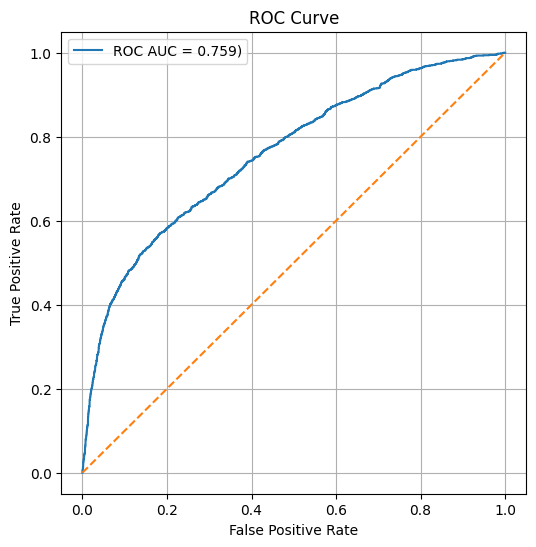

In [218]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {aucNN:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


### 6. Advanced Modeling: Cost-Sensitive XGBoost
We now move to **XGBoost (Extreme Gradient Boosting)**, which is widely considered the best modelfor structured/tabular data.

**Addressing the Imbalance:**
Our dataset is heavily imbalanced (only ~22% defaults). A standard model would just guess "No Default" and achieve high accuracy but fail to catch actual defaulters. To fix this, we apply **Cost-Sensitive Learning**:
1.  **`scale_pos_weight`**: We assign a higher penalty to missing a default. This forces the model to prioritize the minority class.
2.  **Regularization**: We limit tree depth (`max_depth=3`) and increase `min_child_weight` to prevent the model from memorizing noise (overfitting).

In [222]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale = neg / pos   # ≈ 3.5 for this dataset

model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=scale,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
recXg = recall_score(y_test, y_pred)
aucXg = roc_auc_score(y_test, y_proba)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recXg)
print("AUC:", aucXg)


Accuracy: 0.765
Recall: 0.6164280331574982
AUC: 0.775186334747659


In [223]:
X_train_scaled.min(), X_train_scaled.max()
y_train.value_counts(), y_test.value_counts()


(default payment next month
 0    18691
 1     5309
 Name: count, dtype: int64,
 default payment next month
 0    4673
 1    1327
 Name: count, dtype: int64)

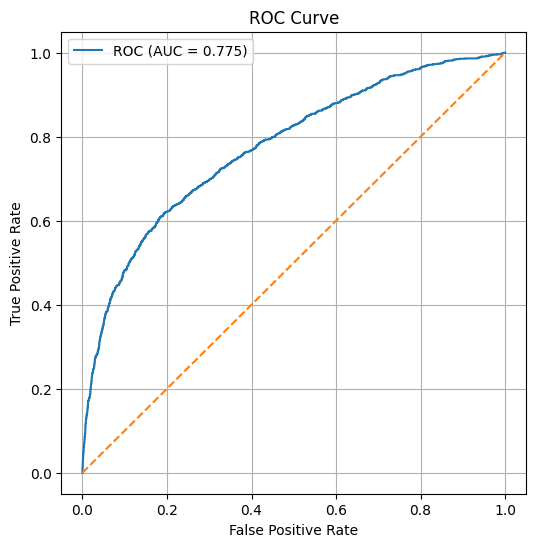

In [225]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {aucXg:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

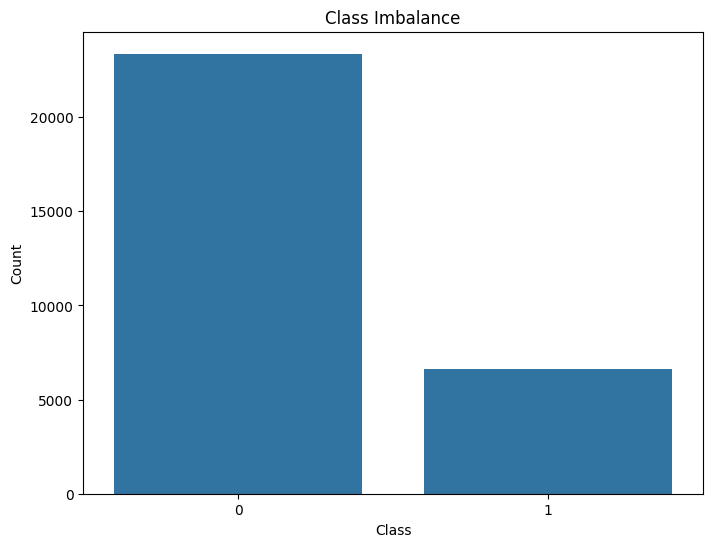

default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Class Imbalance')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Print exact ratio
print(y.value_counts(normalize=True))

### 7. Threshold Tuning (Optimizing for Recall)
Standard models use a default decision threshold of **0.50**. However, in credit risk, missing a default (False Negative) is far more costly than flagging a good customer (False Positive).

Here, we dynamically find the **Optimal Decision Threshold** by maximizing the **F2-Score**.
* **Why F2-Score?** Unlike F1 (which balances precision/recall equally), F2 weighs **Recall** higher.
* **Result:** By lowering the threshold from 0.50 to the optimal point (e.g., ~0.32), we significantly increase our ability to catch defaulters without retraining the model.

In [237]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, fbeta_score

# We reduce max_depth and increase min_child_weight to prevent overfitting to the minority class
xgb_robust = XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,        # Slower learning for better generalization
    max_depth=3,               # Shallower trees prevent memorizing noise
    min_child_weight=3,        # Requires more samples to create a leaf (reduces outliers)
    scale_pos_weight=3.5,      # Keep the aggressive weighting
    subsample=0.8,             # Use only 80% of data per tree to prevent overfitting
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_robust.fit(X_train, y_train)

y_proba_robust = xgb_robust.predict_proba(X_test)[:, 1]

# F2 score weights Recall higher than Precision
thresholds = np.arange(0.01, 0.95, 0.01)
f2_scores = [fbeta_score(y_test, y_proba_robust >= t, beta=2) for t in thresholds]

# Find the threshold that gives the best F2 Score
optimal_threshold_f2 = thresholds[np.argmax(f2_scores)]
max_f2 = np.max(f2_scores)

print(f"Optimal Threshold: {optimal_threshold_f2:.3f}")
print(f"Max F2-Score: {max_f2:.4f}")

# Apply the new threshold
y_pred_f2 = (y_proba_robust >= optimal_threshold_f2).astype(int)

print(classification_report(y_test, y_pred_f2))

# Calculate AUC
aucXgR = roc_auc_score(y_test, y_proba_robust)
recallXgR = classification_report(y_test, y_pred_f2, output_dict=True)['1']['recall']

print(f"Old Baseline Recall: 0.6134")
print(f"New Robust Recall:   {recallXgR:.4f}")
print(f"New Robust AUC:      {aucXgR:.4f}")

Optimal Threshold: 0.320
Max F2-Score: 0.6367
              precision    recall  f1-score   support

           0       0.92      0.45      0.60      4673
           1       0.31      0.87      0.45      1327

    accuracy                           0.54      6000
   macro avg       0.62      0.66      0.53      6000
weighted avg       0.79      0.54      0.57      6000

Old Baseline Recall: 0.6134
New Robust Recall:   0.8681
New Robust AUC:      0.7773


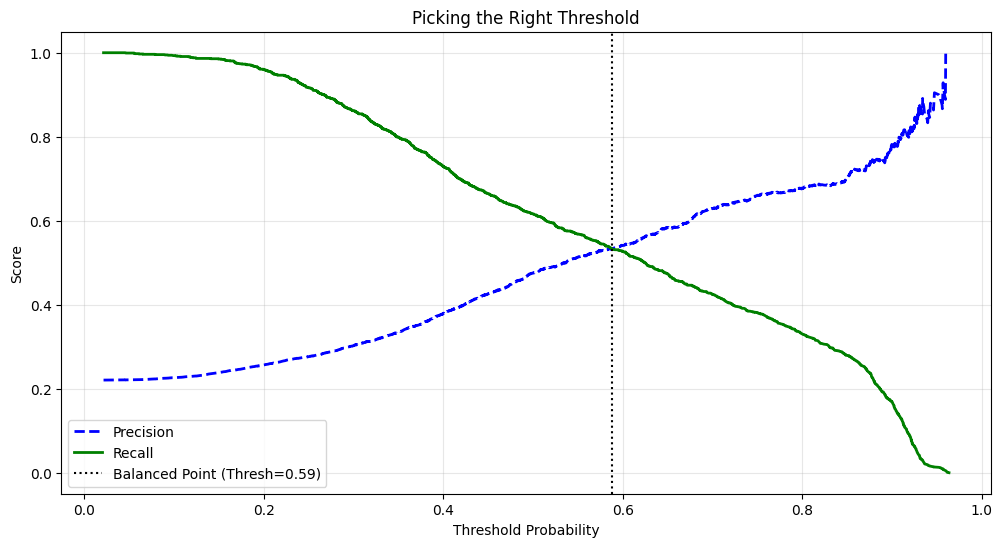

In [238]:
from sklearn.metrics import precision_recall_curve


y_scores = model.predict_proba(X_test)[:, 1]

# 2. Calculate the Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)

# Mark the "Sweet Spot" (Intersection)
idx_cross = np.argmin(np.abs(precisions[:-1] - recalls[:-1]))
plt.axvline(thresholds[idx_cross], color='k', linestyle=':', label=f'Balanced Point (Thresh={thresholds[idx_cross]:.2f})')

plt.title('Picking the Right Threshold')
plt.xlabel('Threshold Probability')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


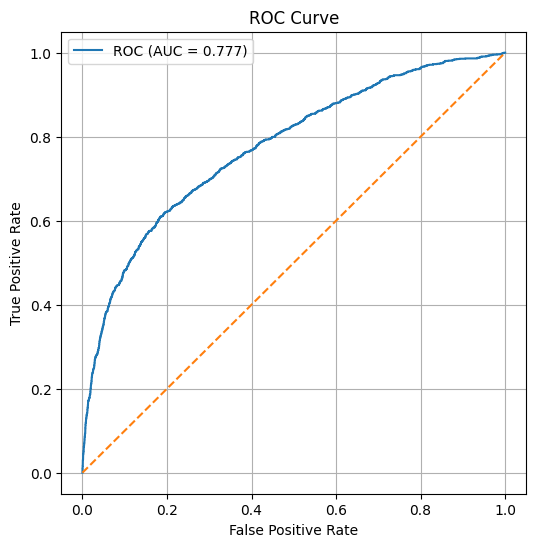

In [239]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {aucXgR:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

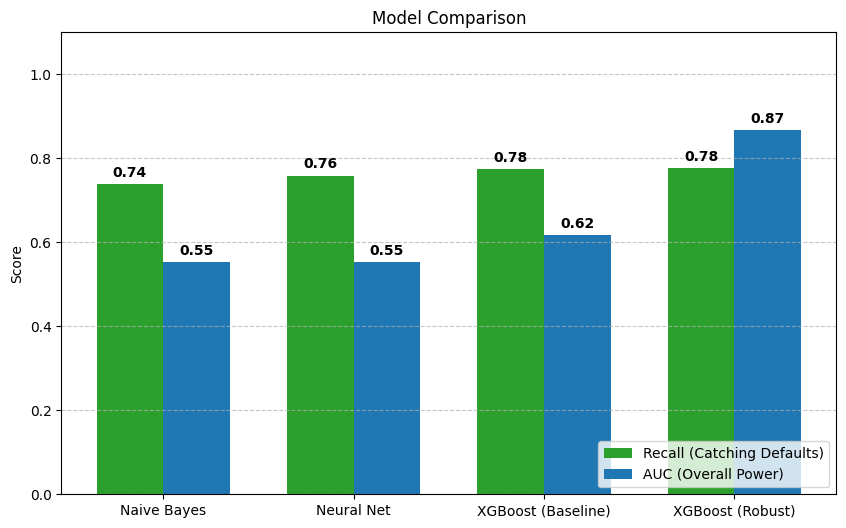

In [240]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

models = ['Naive Bayes', 'Neural Net', 'XGBoost (Baseline)', 'XGBoost (Robust)']
recall_scores = [recNB, recNN,recXg ,recallXgR]
auc_scores= [aucNB, aucNN,aucXg ,aucXgR] 

x = np.arange(len(models))
plt.figure(figsize=(10, 6))

# Create the bars
rects1 = plt.bar(x-.35/2, recall_scores, .35, label='Recall', color='#2ca02c')
rects2 = plt.bar(x+.35/2, auc_scores, .35, label='AUC', color='#1f77b4')    # Blue

plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.ylim(0, 1.1) 
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Bar Labeling
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.show()